# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75.

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели.
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

### Импорт библиотек

In [ ]:
!pip install catboost --upgrade -q

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import seaborn as sns
import sklearn
import re
import time
import nltk
import numpy as np
import spacy
import torch
from joblib import Parallel, delayed
from wordcloud import WordCloud
from matplotlib import pyplot as plt
from google.colab import drive
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords as nltk_stopwords
from nltk.corpus import wordnet
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords
from tqdm.notebook import tqdm

In [ ]:
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
tqdm.pandas()
drive.mount('/content/drive')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#constants
RANDOM_STATE = 42
TEST_SIZE = 0.1

### Загрузка и анализ данных

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/toxic_comments.csv', index_col=0)

display(df.info())
display(df.head())
print(f'\nОбнаружено {df.duplicated().sum()} дубликатов')

<class 'pandas.core.frame.DataFrame'>
Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


None

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0



Обнаружено 0 дубликатов


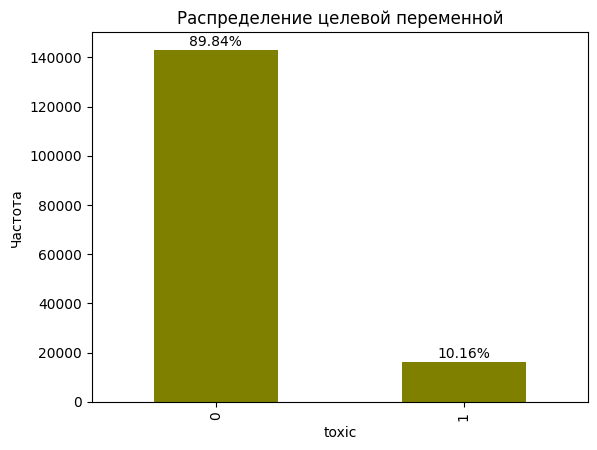

In [ ]:
value_counts = df['toxic'].value_counts()
total = len(df)

ax = value_counts.plot(kind='bar',
                      color='Olive',
                      ylabel='Частота',
                      title='Распределение целевой переменной')

for i, v in enumerate(value_counts):
    percent = f'{(v/total)*100:.2f}%'
    ax.text(i, v + total*0.01, percent, ha='center')

plt.show()

**Вывод:**  
- Данные сооветствую описанию;
- Дубликатов и пропусков нет;
- Удален ненужный признак;
- Токсичных комментариев 10% от общего количества.

### Лемматизация

In [ ]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z']", ' ', text)
    return ' '.join(text.split())

df['text'] = df['text'].progress_apply(clean_text)

df.head(10)

  0%|          | 0/159292 [00:00<?, ?it/s]

,text,toxic
0,explanation why the edits made under my userna...,0
1,d'aww he matches this background colour i'm se...,0
2,hey man i'm really not trying to edit war it's...,0
3,more i can't make any real suggestions on impr...,0
4,you sir are my hero any chance you remember wh...,0
5,congratulations from me as well use the tools ...,0
6,cocksucker before you piss around on my work,1
7,your vandalism to the matt shirvington article...,0
8,sorry if the word 'nonsense' was offensive to ...,0
9,alignment on this subject and which are contra...,0


In [ ]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def lemm_text_spacy(text):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc])

df['lemmatized_text'] = df['text'].progress_apply(lemm_text_spacy)
df.head(10)

  0%|          | 0/159292 [00:00<?, ?it/s]

,text,toxic,lemmatized_text
0,explanation why the edits made under my userna...,0,explanation why the edit make under my usernam...
1,d'aww he matches this background colour i'm se...,0,d'aww he match this background colour I be see...
2,hey man i'm really not trying to edit war it's...,0,hey man I be really not try to edit war it be ...
3,more i can't make any real suggestions on impr...,0,more I can not make any real suggestion on imp...
4,you sir are my hero any chance you remember wh...,0,you sir be my hero any chance you remember wha...
5,congratulations from me as well use the tools ...,0,congratulation from I as well use the tool wel...
6,cocksucker before you piss around on my work,1,cocksucker before you piss around on my work
7,your vandalism to the matt shirvington article...,0,your vandalism to the matt shirvington article...
8,sorry if the word 'nonsense' was offensive to ...,0,sorry if the word ' nonsense ' be offensive to...
9,alignment on this subject and which are contra...,0,alignment on this subject and which be contrar...


<div class="alert alert-info"> <b>Комментарии студентаV1:</b> Изначально начал делать POS-теги, но решил посмотреть на SpaCy, действительно лаконично, решил применить его</div>

In [ ]:
df.duplicated().sum()

np.int64(1243)

In [ ]:
df = df.drop_duplicates()
df.duplicated().sum()

np.int64(0)

### Облако слов

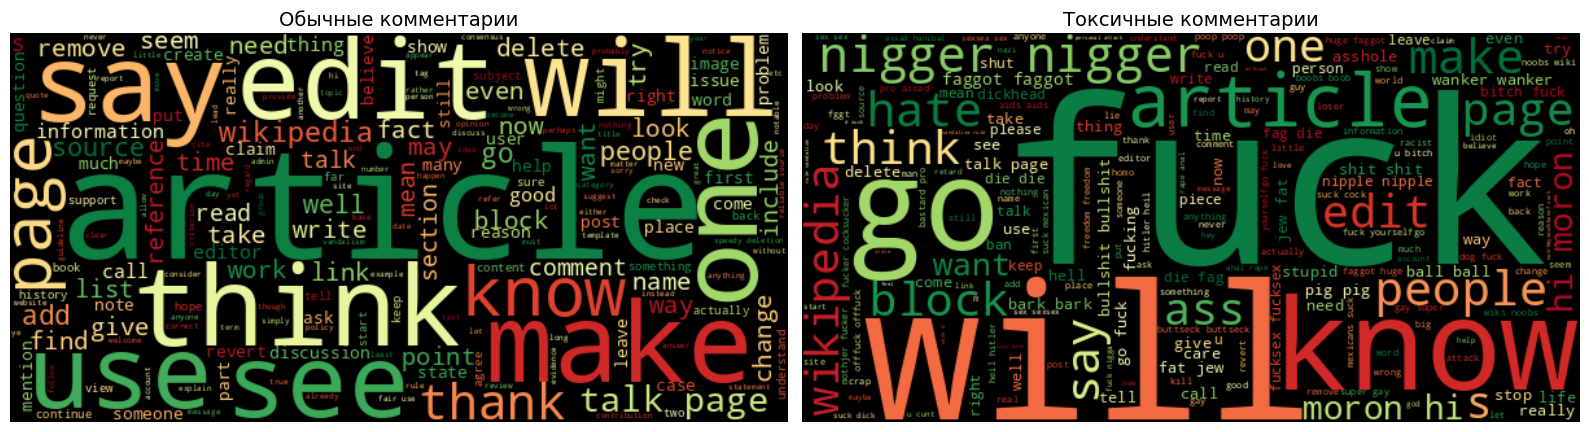

In [ ]:
ordinary_comment = ' '.join(df[df['toxic'] == 0]['lemmatized_text'])
toxic_comment = ' '.join(df[df['toxic'] == 1]['lemmatized_text'])

style = {
    'width': 600,
    'height': 300,
    'background_color': 'black',
    'colormap': 'RdYlGn'
}

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 8))

cloud_ord = WordCloud(**style).generate(ordinary_comment)
ax0.imshow(cloud_ord, interpolation='bilinear')
ax0.set_title('Обычные комментарии', fontsize=14)
ax0.axis('off')

cloud_tox = WordCloud(**style).generate(toxic_comment)
ax1.imshow(cloud_tox, interpolation='bilinear')
ax1.set_title('Токсичные комментарии', fontsize=14)
ax1.axis('off')

plt.tight_layout()
plt.show()

### Подготовка выборок

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['lemmatized_text'],
                                                    df['toxic'],
                                                    test_size = TEST_SIZE,
                                                    random_state = RANDOM_STATE,
                                                    stratify=df['toxic'])

In [ ]:
stopwords = stopwords.words('english')

## Обучение

In [ ]:
start_time_all_fit = time.time()

 ### Модель LogisticRegression

In [ ]:
pipeline_lr = Pipeline([
    ('tfidf', TfidfVectorizer(
        stop_words=stopwords,
        dtype=np.float32
    )),
    ('model', LogisticRegression(
        solver='saga',
        n_jobs=-1,
        warm_start=True
    ))
])

params = {
    'tfidf__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'tfidf__max_features': [5000, 10000],
    'tfidf__norm': ['l1', 'l2'],
    'model__C': np.logspace(-2, 3, 20),
    'model__max_iter': [300, 500, 1000],
    'model__class_weight': [None, 'balanced', {0:1, 1:2}, {0:1, 1:3}]
}

model_lr = RandomizedSearchCV(
    estimator=pipeline_lr,
    param_distributions=params,
    cv=3,
    n_iter=10,
    scoring='f1',
    n_jobs=-1
)

print("Старт обучения...\n")
start_time = time.time()
model_lr.fit(X_train, y_train)
fit_time = time.time() - start_time

print("Реультат обучения:\n")
print(f'Параметры лучшей модели: {model_lr.best_params_}')
print(f'Время обучения: {int(fit_time // 60)} мин. {int(fit_time % 60)} сек.')
print(f'F1-score: {round(model_lr.best_score_, 3)}')

Старт обучения...

Реультат обучения:

Параметры лучшей модели: {'tfidf__norm': 'l2', 'tfidf__ngram_range': (1, 1), 'tfidf__max_features': 5000, 'model__max_iter': 300, 'model__class_weight': None, 'model__C': np.float64(48.32930238571752)}
Время обучения: 9 мин. 23 сек.
F1-score: 0.764


### Модель CatBoostClassifier

In [ ]:
pipe_final = Pipeline([
    ('tfidf', TfidfVectorizer(
        stop_words=stopwords,
        binary=True,
        max_features=15000
    )),
    ('models', CatBoostClassifier(
        verbose=0,
        random_state=RANDOM_STATE,
        early_stopping_rounds=20,
        od_type='Iter',
        task_type='GPU' if torch.cuda.is_available() else 'CPU',
        bootstrap_type='Bernoulli',
        border_count=32,
        allow_writing_files=False
    ))
])

params = {
    'tfidf__ngram_range': [(1, 1)],
    'models__learning_rate': [0.05, 0.1],
    'models__depth': [4, 5],
    'models__iterations': [300, 400],
    'models__l2_leaf_reg': [1, 3]
}

model_cbc = RandomizedSearchCV(
    estimator=pipe_final,
    param_distributions=params,
    cv=2,
    n_iter=5,
    scoring='f1',
    n_jobs=1,
    random_state=RANDOM_STATE,
    verbose=1,
    error_score='raise'
)

print("Старт обучения...\n")
start_time = time.time()
model_cbc.fit(X_train, y_train)
fit_time = time.time() - start_time

print("Реультат обучения:\n")
print(f'Параметры лучшей модели:{model_cbc.best_params_}')
print(f'Время обучения: {int(fit_time // 60)} мин. {int(fit_time % 60)} сек.')
print(f'F1-score: {round(model_cbc.best_score_, 3)}')

Старт обучения...

Fitting 2 folds for each of 5 candidates, totalling 10 fits
Реультат обучения:

Параметры лучшей модели:{'tfidf__ngram_range': (1, 1), 'models__learning_rate': 0.1, 'models__l2_leaf_reg': 1, 'models__iterations': 400, 'models__depth': 5}
Время обучения: 3 мин. 48 сек.
F1-score: 0.72


### Модель CalibratedClassifierCV

In [ ]:
pipe_cc = Pipeline([
    ('tfidf', TfidfVectorizer(
        stop_words=stopwords,
        binary=True,
        dtype=np.float32
    )),
    ('models', CalibratedClassifierCV(
        estimator=LinearSVC(
            class_weight='balanced',
            random_state=RANDOM_STATE,
            dual=False,
            max_iter=1000,
            tol=1e-3
        ),
        method='sigmoid',
        cv=2,
        n_jobs=-1
    ))
])

params = {
    'tfidf__ngram_range': [(1, 1)],
    'tfidf__max_features': [10000],
    'models__estimator__C': [0.1, 1.0, 10.0],
    'models__estimator__penalty': ['l2'],
    'models__estimator__loss': ['squared_hinge'],
    'models__method': ['sigmoid']
}

model_cc = RandomizedSearchCV(
    estimator=pipe_cc,
    param_distributions=params,
    n_iter=5,
    cv=2,
    scoring='f1',
    n_jobs=-1,
    random_state=RANDOM_STATE,
    verbose=2,
    error_score='raise',
    refit=True
)

print("Старт обучения...\n")
start_time = time.time()
model_cc.fit(X_train, y_train)
fit_time = time.time() - start_time

print(f'\nРезультаты:\n')
print(f'Лучшие параметры: {model_cc.best_params_}')
print(f'Время обучения: {int(fit_time // 60)} мин. {int(fit_time % 60)} сек.')
print(f'F1-score: {model_cc.best_score_:.3f}')

Старт обучения...

Fitting 2 folds for each of 3 candidates, totalling 6 fits

Результаты:

Лучшие параметры: {'tfidf__ngram_range': (1, 1), 'tfidf__max_features': 10000, 'models__method': 'sigmoid', 'models__estimator__penalty': 'l2', 'models__estimator__loss': 'squared_hinge', 'models__estimator__C': 0.1}
Время обучения: 0 мин. 46 сек.
F1-score: 0.761


In [ ]:
all_fit_time = time.time() - start_time_all_fit
print(f'Общее время обучения: {int(all_fit_time // 60)} мин. {int(all_fit_time % 60)} сек.')

Общее время обучения: 13 мин. 57 сек.


### Проверка лучшей модели на тестовой выборке

F1-score на тестовых данных: 0.794



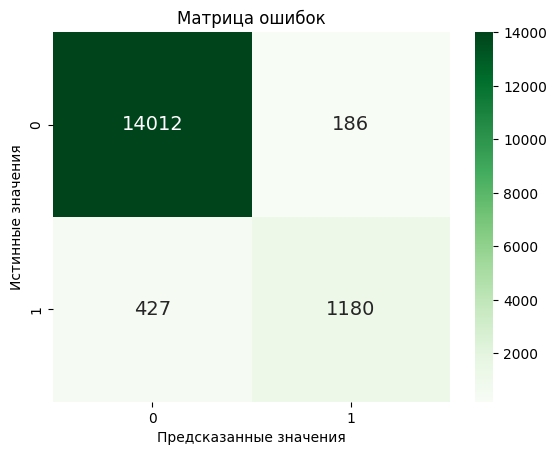

In [ ]:
y_pred = model_lr.predict(X_test)
print(f'F1-score на тестовых данных: {f1_score(y_test, y_pred):.3f}\n')
conf_m = confusion_matrix(y_test, y_pred)

sns.heatmap(
    conf_m,
    annot=True,
    fmt='d',
    cmap='Greens',
    annot_kws={'fontsize': 14}
    )
plt.ylabel('Истинные значения')
plt.xlabel('Предсказанные значения')
plt.title('Матрица ошибок')
plt.show()

In [ ]:
fn_rate = (conf_m[1][0] / (conf_m[1][0] + conf_m[1][1])) * 100
print(f'Имеем {conf_m[1][0]} ложноотрицательных предсказаний или {fn_rate:.2f}%')

Имеем 427 ложноотрицательных предсказаний или 26.57%


## Выводы

- Провели загрузку и первичный анализ данных;
- Подготовили данные и выборки для обучения моделей;
- Произвели обучение трёх моделей, а именно: LogisticRegression, CatBoostClassifier и CalibratedClassifierCV.  

Результатом обучения стали лучшие параметры и метрика F1 для каждой из моделей, исходя из полученых начений мы получили лучшую модель с метрикой F1=0.764, что соответствует цели не менее 0.75.  
  
Проверка модели на тестовой выборке подтвердила оценку качества, которая стала даже выше 0.794.  
  
На основании выше сказаного, рекомендуется использовать модель LogisticRegression, она оказалась наиболее качественной.